#  INIT

In [1]:
import sys
sys.path.append('../../')
sys.path.append('../../infras/')
sys.path.append('../../infras/cellMix/')
sys.path.append('../../infras/dashboards/')
sys.path.append('../../infras/cytof_data/')
sys.path.append('../../preprocess/intra_variance/')



from aggregate_intra_variance import AggregateIntraVariance
from pp_clean_high_intra_var import PpCleanHighIntraVar
from cellMix_coordinator import CellMixCoordinator
from cytof_cell_count_infra import CytofCellCountInfra

import exploration_plots
import dashs

%matplotlib inline

In [2]:
cluster_info_path= r"../../infras/cytof_data/raw_data/CyTOF.features.and.clusters.info.xlsx"
cytof_data_path=r"../../infras/cytof_data/raw_data/filtered.esetALL.CyTOF.abundance.only.xlsx"

cci = CytofCellCountInfra(cluster_info_path,cytof_data_path)


In [3]:
import pandas as pd
import numpy as np
from functools import partial
import multiprocessing

from itertools import chain
from scipy.optimize import least_squares
from sklearn.metrics import mean_squared_error
from functools import partial
from scipy.optimize import minimize
import scipy.optimize
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
import math


from scipy.stats import entropy
from functools import reduce
import matplotlib.patches as patches


import os

In [4]:
from deconv_py.preprocess.base import BasePreprocess as PP_base
from deconv_py.preprocess.cell_specific import CellSpecific as PP_proteins

from deconv_py.infras.data_factory import DataFactory
from deconv_py.infras.data_loader import DataLoader

from deconv_py.models.base import Base as Models_base
from deconv_py.models.cell_proportions_models import CellProportions
from deconv_py.models.cell_specific_models import CellSpecificPerPermutation

from deconv_py.experiments.cell_specific import CellSpecificMetricsPlot

# from deconv_py.infras.cellMix.cellMix_coordinator import CellMixCoordinator

In [5]:
data_loader = DataLoader(mass_spec_path=os.path.abspath('../../data/20190801_filtered_imputed_data.csv'),
                         protein_profile_path = os.path.abspath('../../data/20150718_Cerberus_proteinGroups.txt'),as_csv = True)
data_factory = DataFactory(data_loader)
ms = data_loader.get_mass_spec_data()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: DtypeWarning: Columns (5,6,2764,2765,2773,2774,2775,2776) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
from deconv_py.preprocess.cell_specifics.pp_clean_irrelevant_proteins import PpCleanIrrelevantProteins
from deconv_py.preprocess.cell_specifics.pp_entropy_based import PpEntropyBased
from deconv_py.models.cell_proportions.basic import BasicDeconv

In [7]:
%connect_info

{
  "shell_port": 63497,
  "iopub_port": 63498,
  "stdin_port": 63499,
  "control_port": 63500,
  "hb_port": 63501,
  "ip": "127.0.0.1",
  "key": "59462bd0-1e3e72a9121a04952c2611ec",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-2bcdae8a-b0cc-4d26-84d4-1de0e3afb2c8.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


# read and build data sets - pick and filter intra var agg

## read protein profile and mixtures 

**LFQ:** rel. quantification – for same protein across different samples

**iBAQ:** orthogonal comparison – for different proteins in the same sample

**Intensity:** supposed  to be both


In [8]:
A_intensity,B_intensity = data_factory.load_IBD_all_vs("LFQ intensity",index_func=lambda x:x.split(';')[0],log2_transformation=True,auto_filter_by = True)

# #filter intraVar
filt = PpCleanHighIntraVar(how="std")
A_intensity,B_intensity = filt.transform([A_intensity,B_intensity])

#agg intravar
agg_iv = AggregateIntraVariance(how="median")
A_intensity,_ = agg_iv.transform([A_intensity,None])



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DtypeWarning: Columns (5,6,2764,2765,2773,2774,2775,2776) have mixed types. Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.


## read GX of mixtures

In [9]:
B_gx_ibd = pd.read_csv("../../data/gene_expression/IBD_mixtures_GX/IBD_GX_DATA.csv")
B_gx_ibd = B_gx_ibd.rename(columns={'Unnamed: 0':"Gene names"}).set_index("Gene names")
# mean of dulpicate genes : 
B_gx_ibd = 2**(B_gx_ibd)
B_gx_ibd = B_gx_ibd.groupby(level=0).mean()

## read gene expression data from human protein atlas 

**Transcript expression levels summarized per gene in 18 blood cell types and total PBMC** 


**protein-coding transcripts per million ("pTPM"):** 
fraction of transcripts per million of total transcripts from protein-coding genes - The pTPM values can be used to investigate the abundance of a particular gene, gene family, or gene class relative to all other transcripts in a particular cell, tissue, or organ. 

**normalized expression ("NX"):**
The objective of using the NX value is to facilitate the
analysis of differences in expression of genes
between cells, tissues, and organs and to allow for a specificity classification based on the
genome-wide expression of all genes across the
human blood cells, tissues, and organs.

***The data is based on The Human Protein Atlas version 19.1 and Ensembl version 92.38.


In [10]:
rna_blood_cell_df = pd.read_csv("../../data/gene_expression/human atlas/rna_blood_cell.tsv",sep="\t")
rna_blood_cell_df =rna_blood_cell_df.loc[~rna_blood_cell_df[["Gene name","Blood cell"]].duplicated()]
rna_blood_cell_df = rna_blood_cell_df.rename(columns = {"Gene name" : "Gene names"})

tpm_rna_cell_df = rna_blood_cell_df.pivot(index = "Gene names",columns="Blood cell",values="pTPM")
nx_rna_cell_df = rna_blood_cell_df.pivot(index = "Gene names",columns="Blood cell",values="NX")

In [11]:
nx_rna_cell_df_tc = nx_rna_cell_df.copy(deep=True)
tpm_rna_cell_df_tc = tpm_rna_cell_df.copy(deep=True)

## build corresponding sets

1) we start with indexing the genes  - we use only the genes as key  

### keep only genes as index

In [12]:
#keep only genes as levels
B_intensity.index = B_intensity.index.droplevel(level="major_protein_id")
A_intensity.index = A_intensity.index.droplevel(level="major_protein_id")

### rename mixtures name

In [13]:
def return_low_case(p,v) :
    return f"{p}_v{v}"

B_gx_ibd = B_gx_ibd.rename(columns = {col:return_low_case(col.split("-")[1],col.split("-")[2][1]) for col in B_gx_ibd.columns})
B_intensity = B_intensity.rename(columns = {col:return_low_case(col.split("_")[0],col.split("_")[1][1]) for col in B_intensity.columns})

### keep corresponding genes as index

In [14]:
def return_corosponding(home_profile,out_profile,filter_by_mutual_mixtures = True) : 
    def get_home_cor_gene(out_gene,mut_genes_multiple,mut_genes):
        if out_gene in mut_genes : 
            return out_gene
        if out_gene in mut_genes_multiple.keys():
            return mut_genes_multiple[out_gene]

    out_genes = out_profile.index.dropna().drop_duplicates()
    home_genes = home_profile.index.dropna().drop_duplicates()

    home_genes_multiple = [genes for genes in home_genes if ";" in genes] 
    mut_genes_multiple = {}
    for out_gene in out_genes : 
        for home_gene in home_genes_multiple:
            if out_gene in home_gene:
                mut_genes_multiple[out_gene] = home_gene

    mut_genes = out_genes.intersection(home_genes)
    
    filt_out_profile = out_profile.copy(deep=True).loc[mut_genes.union(pd.Index(mut_genes_multiple.keys()))]
    filt_out_profile["home_cor_gene"] = filt_out_profile.index.map(lambda out_gene:get_home_cor_gene(out_gene,mut_genes_multiple,mut_genes))
    #mean the duplicates : 
    filt_out_profile = filt_out_profile.groupby("home_cor_gene").mean()
    filt_out_profile.index.names = ["Gene names"]
    filt_home_profile = home_profile.loc[filt_out_profile.index].reset_index().groupby("Gene names").mean()
    
    if filter_by_mutual_mixtures : 
        mutual_mixtures = pd.Index(filt_out_profile.columns).intersection(pd.Index(filt_home_profile.columns))
        return  filt_home_profile[mutual_mixtures],filt_out_profile[mutual_mixtures]
    return  filt_home_profile,filt_out_profile

#keep mutual genes , consider multiple genes with ;,keep mutual mixtures
B_intensity,B_gx_ibd = return_corosponding(B_intensity,B_gx_ibd)
A_intensity,_ = return_corosponding(A_intensity,B_gx_ibd,False)
_,nx_rna_cell_df=return_corosponding(A_intensity,nx_rna_cell_df,False)
_,tpm_rna_cell_df=return_corosponding(A_intensity,tpm_rna_cell_df,False)

mutual_indexs = B_intensity.index.intersection(B_gx_ibd.index.intersection(nx_rna_cell_df.index.intersection(nx_rna_cell_df.index))) 

B_intensity,B_gx_ibd,A_intensity,nx_rna_cell_df,tpm_rna_cell_df = B_intensity.loc[mutual_indexs],B_gx_ibd.loc[mutual_indexs],A_intensity.loc[mutual_indexs],nx_rna_cell_df.loc[mutual_indexs],tpm_rna_cell_df.loc[mutual_indexs]


### rebuild human atlas profile as massSpec profile

In [15]:
mass_cell_to_gene_cell_map = {'NOT_BCellmemory': 'memory B-cell',
                                  'NOT_BCellnaive' : 'naive B-cell',
                                  'NOT_BCellplasma' : None,
                                  'NOT_CD4TCellmTregs' : 'T-reg',
                                  'NOT_CD4TCellnaive':'naive CD4 T-cell',
                                  'NOT_CD4TCellnTregs':'T-reg',
                                  'NOT_CD4TCellTcm' : 'memory CD4 T-cell' ,
                                  'NOT_CD4TCellTem' : None,
                                  'NOT_CD4TCellTemra' :None,
                                  'NOT_CD4TCellTh1':None,
                                  'NOT_CD4TCellTh17':None,
                                  'NOT_CD4TCellTh2':None,
                                  'NOT_CD8TCellnaive':'naive CD8 T-cell',
                                  'NOT_CD8TCellTcm' : 'memory CD8 T-cell',
                                  'NOT_CD8TCellTem' : None ,
                                  'NOT_CD8TCellTemra' : None,
                                  'NOT_DendriticCD1c' : None,
                                  'NOT_DendriticCD304' : None,
                                  'NOT_Erythrocytes' : None,
                                  'NOT_Monocytesclassical': 'classical monocyte' ,
                                  'NOT_Monocytesintermediate' : 'intermediate monocyte',
                                  'NOT_Monocytesnonclassical': 'non-classical monocyte',
                                  'NOT_NKCellsCD56bright' : 'NK-cell',
                                  'NOT_NKCellsCD56dim': 'NK-cell',
                                  'NOT_Thrombocytes' : None,
                                  'NOT_Granulocyteseosinophils' : "eosinophil",
                                  'NOT_GranulocytesBasophil' : "basophil"}

new_mass_cell_to_gene_cell_map = {}
for cell_from_profile in A_intensity.columns :
    corr_cell_in_map = [c for c in mass_cell_to_gene_cell_map if c in cell_from_profile ]
    if len(corr_cell_in_map) == 0 :
        new_mass_cell_to_gene_cell_map[cell_from_profile] = None
    else :
        new_mass_cell_to_gene_cell_map[cell_from_profile] = mass_cell_to_gene_cell_map[corr_cell_in_map[0]]

mass_cell_to_gene_cell_map = new_mass_cell_to_gene_cell_map
gene_cell_to_mass_cell_map = {v:k for k,v in mass_cell_to_gene_cell_map.items()}

nx_rna_cell_df = nx_rna_cell_df.rename(columns=gene_cell_to_mass_cell_map)
nx_rna_cell_df = nx_rna_cell_df.loc[:,nx_rna_cell_df.columns.isin(gene_cell_to_mass_cell_map.values())]

tpm_rna_cell_df = tpm_rna_cell_df.rename(columns=gene_cell_to_mass_cell_map)
tpm_rna_cell_df = tpm_rna_cell_df.loc[:,tpm_rna_cell_df.columns.isin(gene_cell_to_mass_cell_map.values())]

In [16]:
# tpm_rna_cell_df


## read Cytof data per profile matrix (because of label propagation )

In [17]:
cytof_label_prop_A_ints = cci.cytof_label_propagation(A_intensity)
A_intensity_Cytof_cell,cytof_count_of_A_intensity = cci.return_mass_and_cytof_not_none_cells_counts(A_intensity.T,cytof_label_prop_A_ints)
A_intensity_Cytof_cell = A_intensity_Cytof_cell.T

In [18]:
nx_rna_Cytof_cell,cytof_count_of_nx_rna = cci.return_mass_and_cytof_not_none_cells_counts(nx_rna_cell_df.T,filter_by_version="",is_mean_agg=True)
nx_rna_Cytof_cell = nx_rna_Cytof_cell.T

tpm_rna_Cytof_cell,cytof_count_of_tpm_rna = cci.return_mass_and_cytof_not_none_cells_counts(tpm_rna_cell_df.T,filter_by_version="",is_mean_agg=True)
tpm_rna_Cytof_cell = tpm_rna_Cytof_cell.T

In [19]:
def read_granulocytes_proportions(path=r"C:\Repos\deconv_py\deconv_py\infras\cytof_data\raw_data\filtered.esetALL.CyTOF.abundance.only.xlsx"):
    # the cluster from the citros we took is all the granulocytes!!! so the proportion of the granulocytes in the mixture is all there is
    all_data =  pd.read_excel(cytof_data_path).rename(columns = {'Unnamed: 0' : "mixtures"}).set_index("mixtures")
    return all_data[["GR.TOTAL","PB.TOTAL"]]
gran_proportions = read_granulocytes_proportions()


In [20]:
cytof_count_of_A_intensity = cytof_count_of_A_intensity.rename(columns = {col:return_low_case(col.split("-")[1],col.split("-")[2][1]) for col in cytof_count_of_A_intensity.columns})
cytof_count_of_nx_rna = cytof_count_of_nx_rna.rename(columns = {col:return_low_case(col.split("-")[1],col.split("-")[2][1]) for col in cytof_count_of_nx_rna.columns})
cytof_count_of_tpm_rna = cytof_count_of_tpm_rna.rename(columns = {col:return_low_case(col.split("-")[1],col.split("-")[2][1]) for col in cytof_count_of_tpm_rna.columns})

In [21]:
gran_proportions = gran_proportions.rename(index = {col:return_low_case(col.split("-")[1],col.split("-")[2][1]) for col in gran_proportions.index})

# code base

In [22]:
def plot_expcted_mixtures_vs_real_mixtures(expcted_mixtures,real_mixtures,percantile_to_take = 1,lims = [[-1,30],[4,21]],as_log=True,correlation_type =  "spearman"):
    fig, axs = plt.subplots(math.ceil(len(expcted_mixtures.columns)/2),2,figsize=(15,45))

    for mixture,ax in zip(expcted_mixtures.columns,axs.reshape(-1)) :
        if mixture not in real_mixtures : 
            continue
        
        expcted_mixture_expression = expcted_mixtures[mixture]
        real_mixture_expression = real_mixtures[mixture]
        
        exp_robust = expcted_mixtures[expcted_mixtures <= expcted_mixtures.quantile(percantile_to_take)].dropna().index
        B_robust = real_mixtures[real_mixtures <= real_mixtures.quantile(percantile_to_take)].dropna().index
        mutual_robust = exp_robust.intersection(B_robust)
        
        expcted_mixture_expression = expcted_mixture_expression.loc[mutual_robust]
        real_mixture_expression = real_mixture_expression.loc[mutual_robust]
        
        if as_log : 
            x = np.log(1+expcted_mixture_expression)
            y = np.log(1+real_mixture_expression)
        else : 
            x = expcted_mixture_expression
            y = real_mixture_expression

        correlation_with_out_zeros = np.round(real_mixture_expression[x != 0].corr(expcted_mixture_expression[x != 0],method=correlation_type),3)
        xy = np.vstack([x,y])
        z = gaussian_kde(xy)(xy)

        ax.scatter(x, y, c=z,s=100)
        ax.set_title(f"{mixture}, {correlation_type} of non zeros(real not log) : {correlation_with_out_zeros}")
        ax.set_xlabel("log(1+expcted)")
        ax.set_ylabel("log(1+real)")
        
        if lims is not None : 
            ax.set_xlim(lims[0])
            ax.set_ylim(lims[1])
    print("here")
    plt.show()
    plt.subplots_adjust(hspace=0.5)  

In [23]:
def plot_expcted_mixtures_vs_real_mixtures_with_intravar_filter(expcted_mixtures,real_mixtures,percantile_to_take = 1,lims = [[-1,30],[4,21]],as_log=True,correlation_type =  "spearman"):    
    melted_expcted_mixtures = pd.melt(expcted_mixtures.reset_index(),id_vars="Gene names").set_index(["Gene names","mixtures"])["value"]
    melted_real_mixtures = pd.melt(real_mixtures.reset_index(),id_vars="Gene names").rename(columns = {"variable":"mixtures"}).set_index(["Gene names","mixtures"])["value"]

    exp_robust = melted_expcted_mixtures[melted_expcted_mixtures <= melted_expcted_mixtures.quantile(percantile_to_take)].dropna().index
    B_robust = melted_real_mixtures[melted_real_mixtures <= melted_real_mixtures.quantile(percantile_to_take)].dropna().index
    mutual_robust = exp_robust.intersection(B_robust)

    melted_expcted_mixtures = melted_expcted_mixtures.loc[mutual_robust]
    melted_real_mixtures = melted_real_mixtures.loc[mutual_robust]

    
    if as_log : 
        x = np.log(1+melted_expcted_mixtures)
        y = np.log(1+melted_real_mixtures)
    else : 
        x = melted_expcted_mixtures
        y = melted_real_mixtures
    
    correlation_with_out_zeros = np.round(melted_real_mixtures[x != 0].corr(melted_expcted_mixtures[x != 0],method=correlation_type),3)
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    
    fig, axs = plt.subplots(3,1)

    axs[0].scatter(x, y, c=z,s=100)
    axs[0].set_title(f" {correlation_type} of non zeros(real not log) : {correlation_with_out_zeros}")
    axs[0].set_xlabel("log(1+expcted)")
    axs[0].set_ylabel("log(1+real)")

    if lims is not None : 
        axs[0].set_xlim(lims[0])
        axs[0].set_ylim(lims[1])

    plt.subplots_adjust(hspace=0.9)  

In [24]:
def corr_expcted_vs_mixture(expcted_b,B,method  = "pearson",n_to_take = 10):
    corr_per_mixture_df = pd.DataFrame(index= B.columns)

    for i in np.linspace(0.45,0.95,10) :
        trh = round(i,2)

        for mixture_idx in B:
            mixture =np.log2(B[mixture_idx])
            mixture = B[mixture_idx]
            mixture[B[mixture_idx] == 0] = 0
            mixture_trh = mixture.quantile(trh)
            relevant_proteins = mixture[mixture>mixture_trh].index

            _expcted_b = np.log2(expcted_b[mixture_idx])
            _expcted_b = expcted_b[mixture_idx]
            _expcted_b[expcted_b[mixture_idx] ==0] = 0
            corr = _expcted_b.loc[relevant_proteins].corr(mixture.loc[relevant_proteins],method = method)
            corr_per_mixture_df.ix[mixture_idx,trh] = corr
    corr_per_mixture_df.T.sample(n=n_to_take,axis=1).plot(title=f"correlation mixture vs expcted_mixture - {method}")

# protein figures

## build expected mixtures

In [25]:
expected_mixtures_intensity =  A_intensity_Cytof_cell.dot(cytof_count_of_A_intensity)

## protein profile with  cytof to protein - no Total counts

### expected_mixtures vs real_mixtures

here


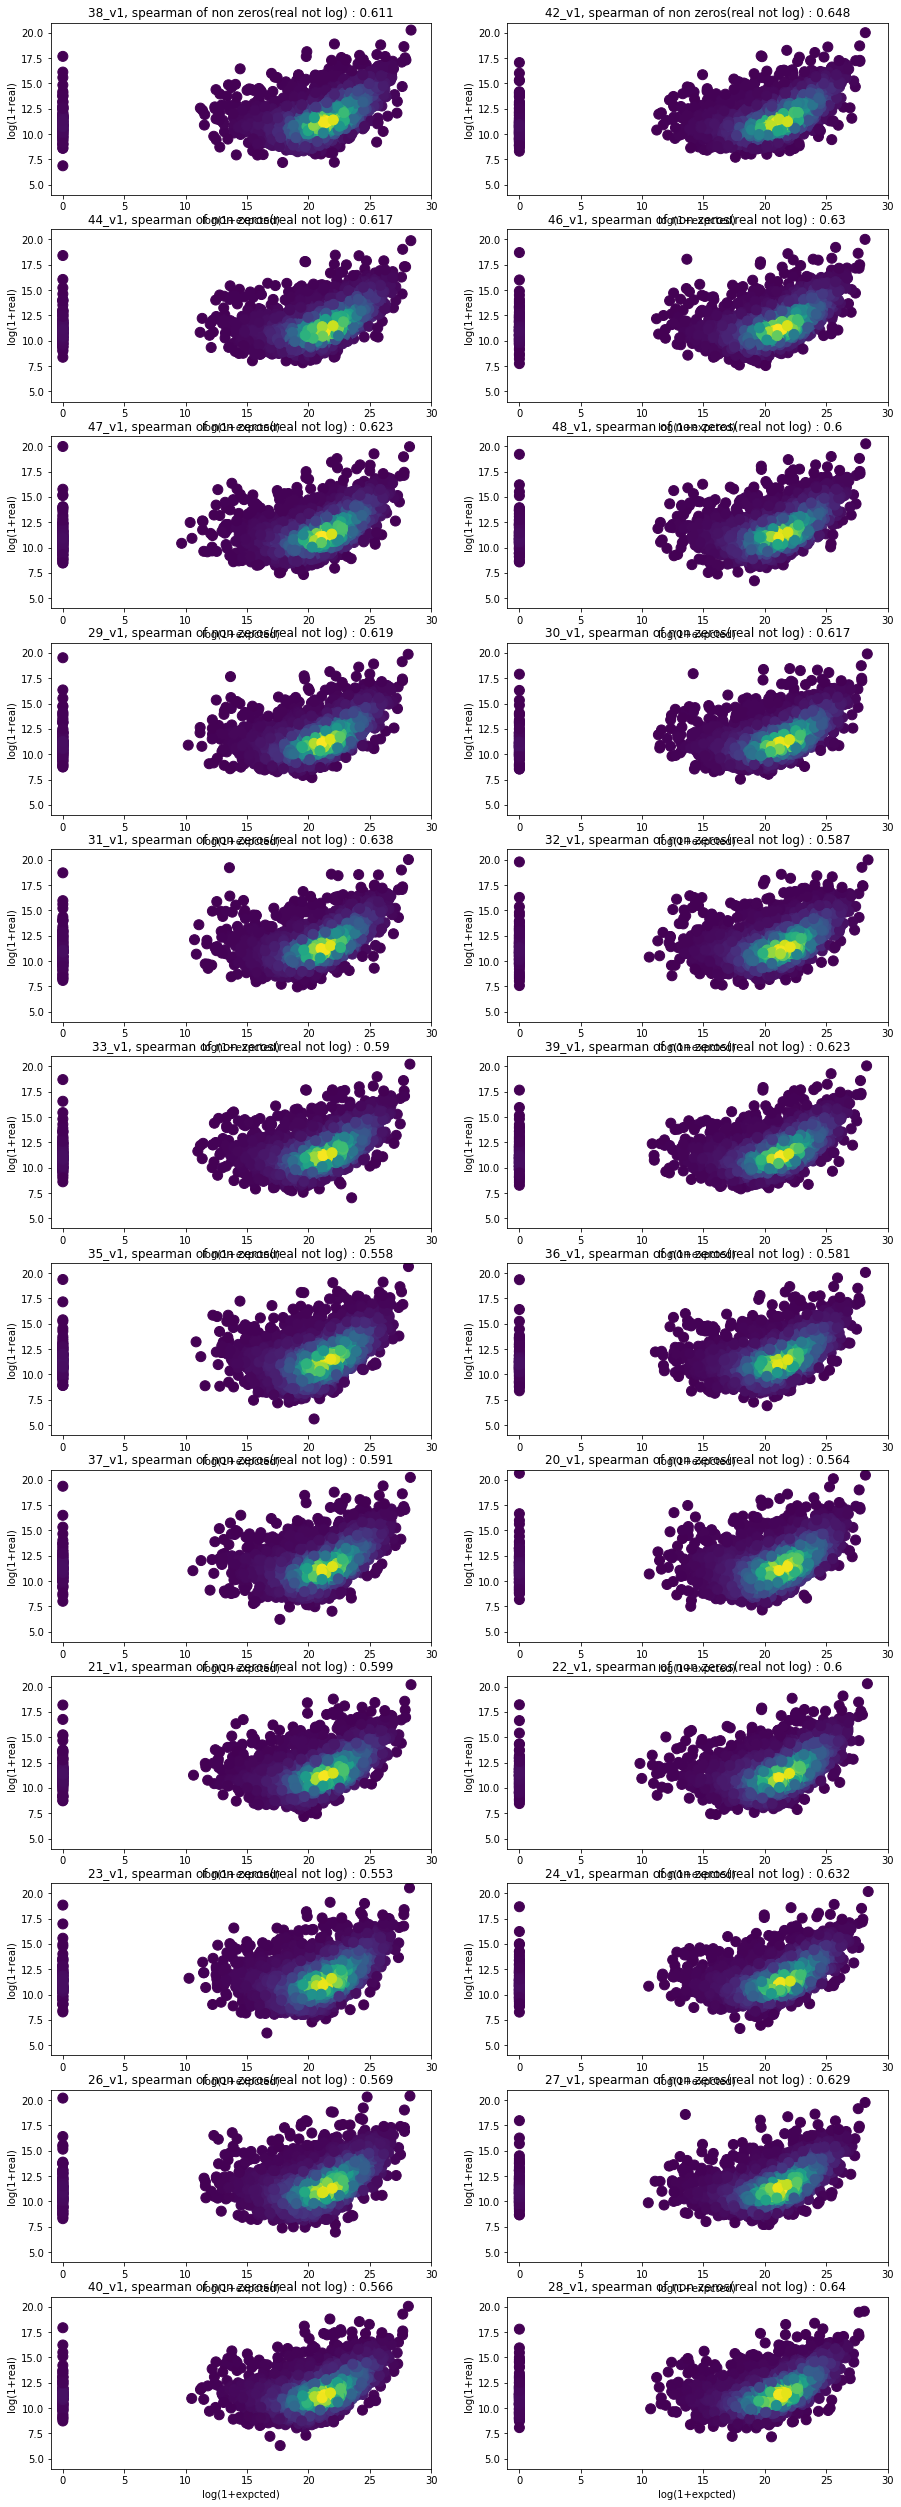

<Figure size 432x288 with 0 Axes>

In [26]:
plot_expcted_mixtures_vs_real_mixtures(expected_mixtures_intensity,B_intensity)
# plt.savefig("save_me_to_the_end_of_time")

### expected_mixtures vs real_mixtures - top 90%

here


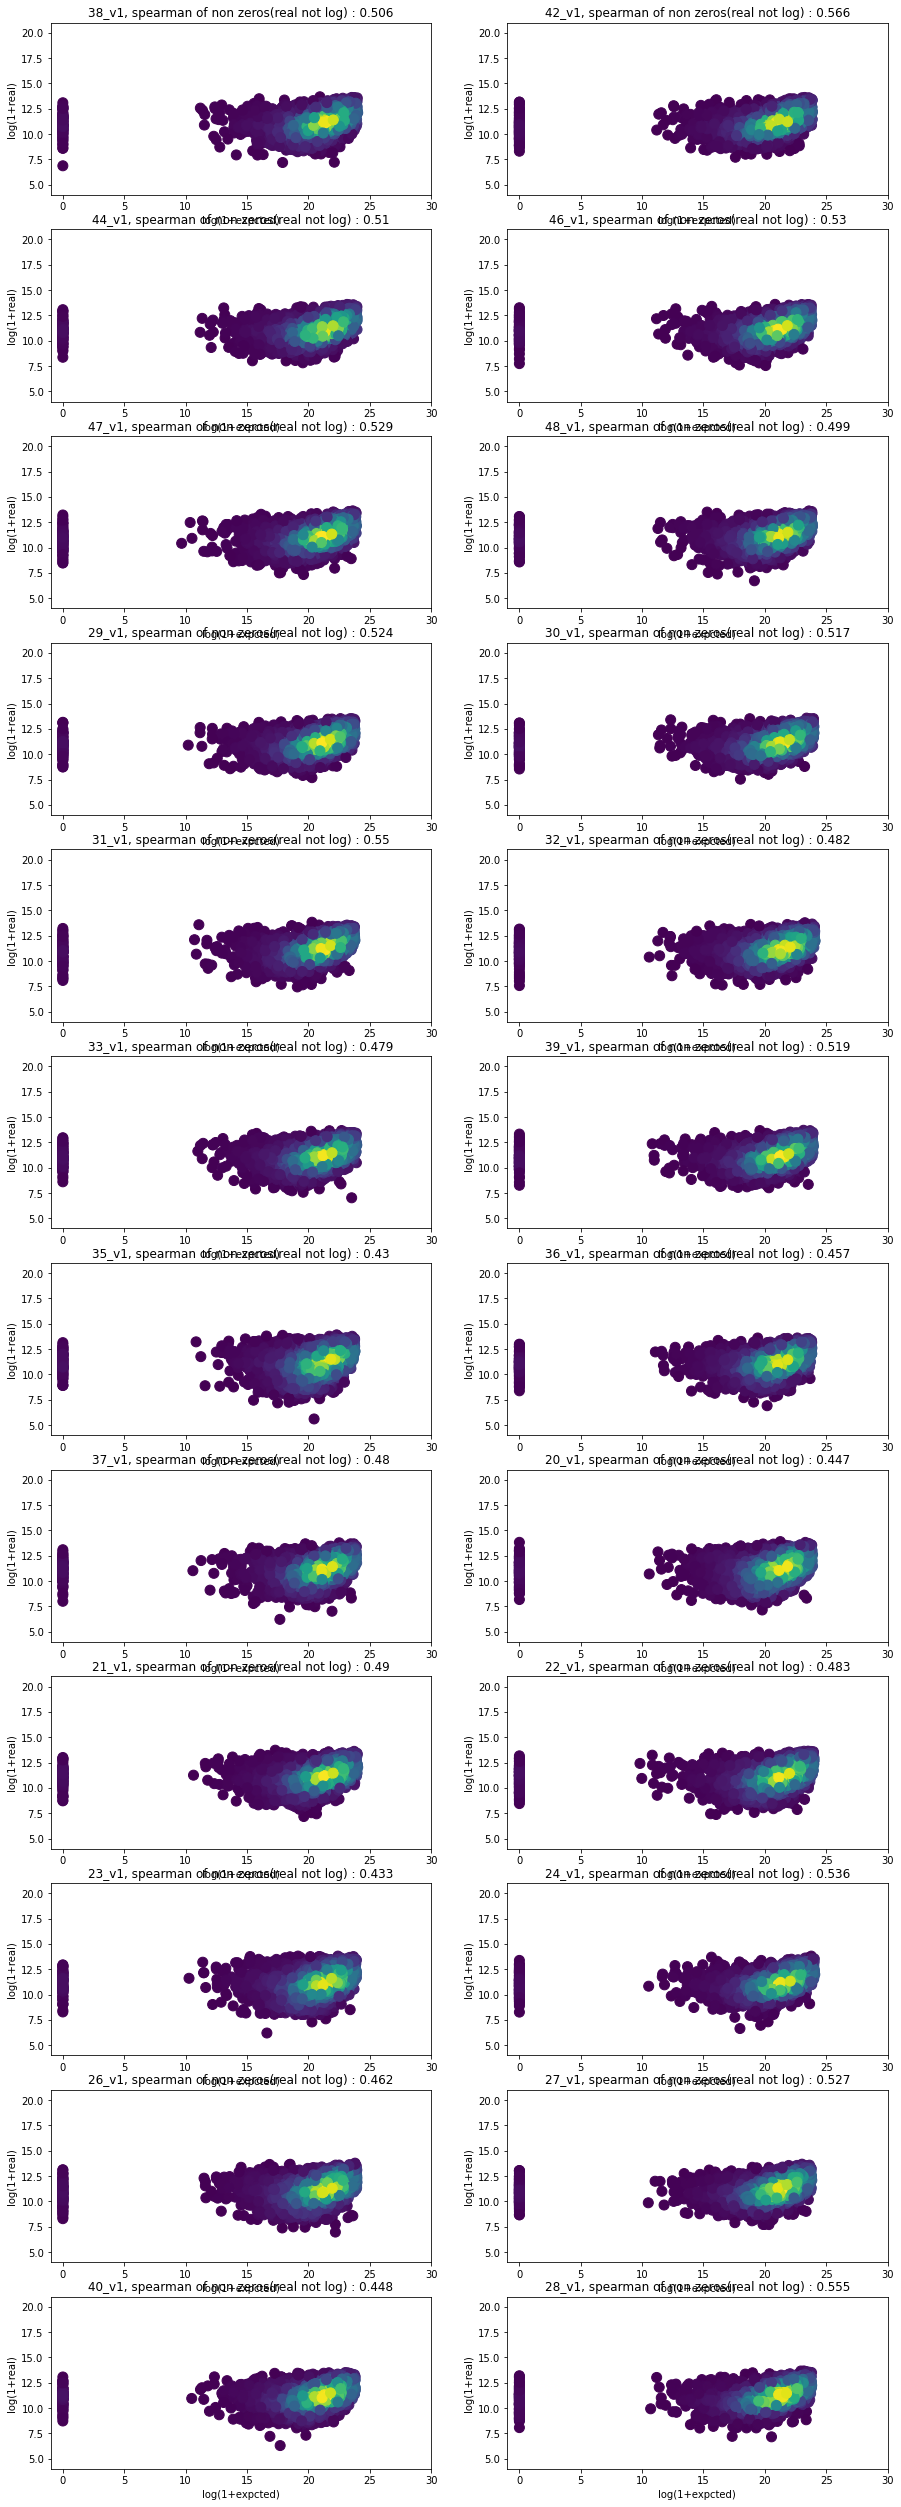

<Figure size 432x288 with 0 Axes>

In [27]:
plot_expcted_mixtures_vs_real_mixtures(expected_mixtures_intensity,B_intensity,percantile_to_take=0.9)

### correlation per percentile expected_mixtures vs real_mixtures

C:\Users\Shenorr\AppData\Roaming\Python\Python36\site-packages\pandas\core\generic.py:9114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Shenorr\AppData\Roaming\Python\Python36\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: 
.ix is deprecated.

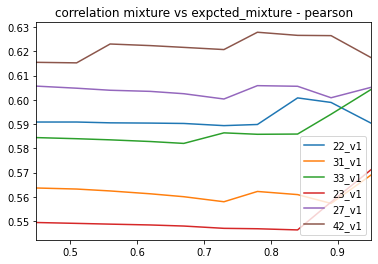

In [28]:
corr_expcted_vs_mixture(expected_mixtures_intensity,B_intensity[expected_mixtures_intensity.columns],n_to_take=6)

## protein profile with  cytof to protein - with Total counts

### rebuild profile with total counts

In [29]:
def return_tc(cell,total_counts_map) : 
    for c_type,count in total_counts_map.items() : 
        if c_type in cell :
            return count
    return 1

_total_counts_map = {"B":94.01,"4":13.71,
                    "CD8":19.39,"Monocyt":28.97}
specific_cell_to_tc = {cell:return_tc(cell,_total_counts_map) for cell in A_intensity_Cytof_cell.columns}

A_intensity_Cytof_cell_tc = A_intensity_Cytof_cell.copy(deep=True)

for cell in A_intensity_Cytof_cell_tc.columns : 
    A_intensity_Cytof_cell_tc[cell] = A_intensity_Cytof_cell_tc[cell] * specific_cell_to_tc[cell]

### build expected mixtures

In [30]:
expected_mixtures_intensity_tc =  A_intensity_Cytof_cell_tc.dot(cytof_count_of_A_intensity)

### expected_mixtures vs real_mixtures

here


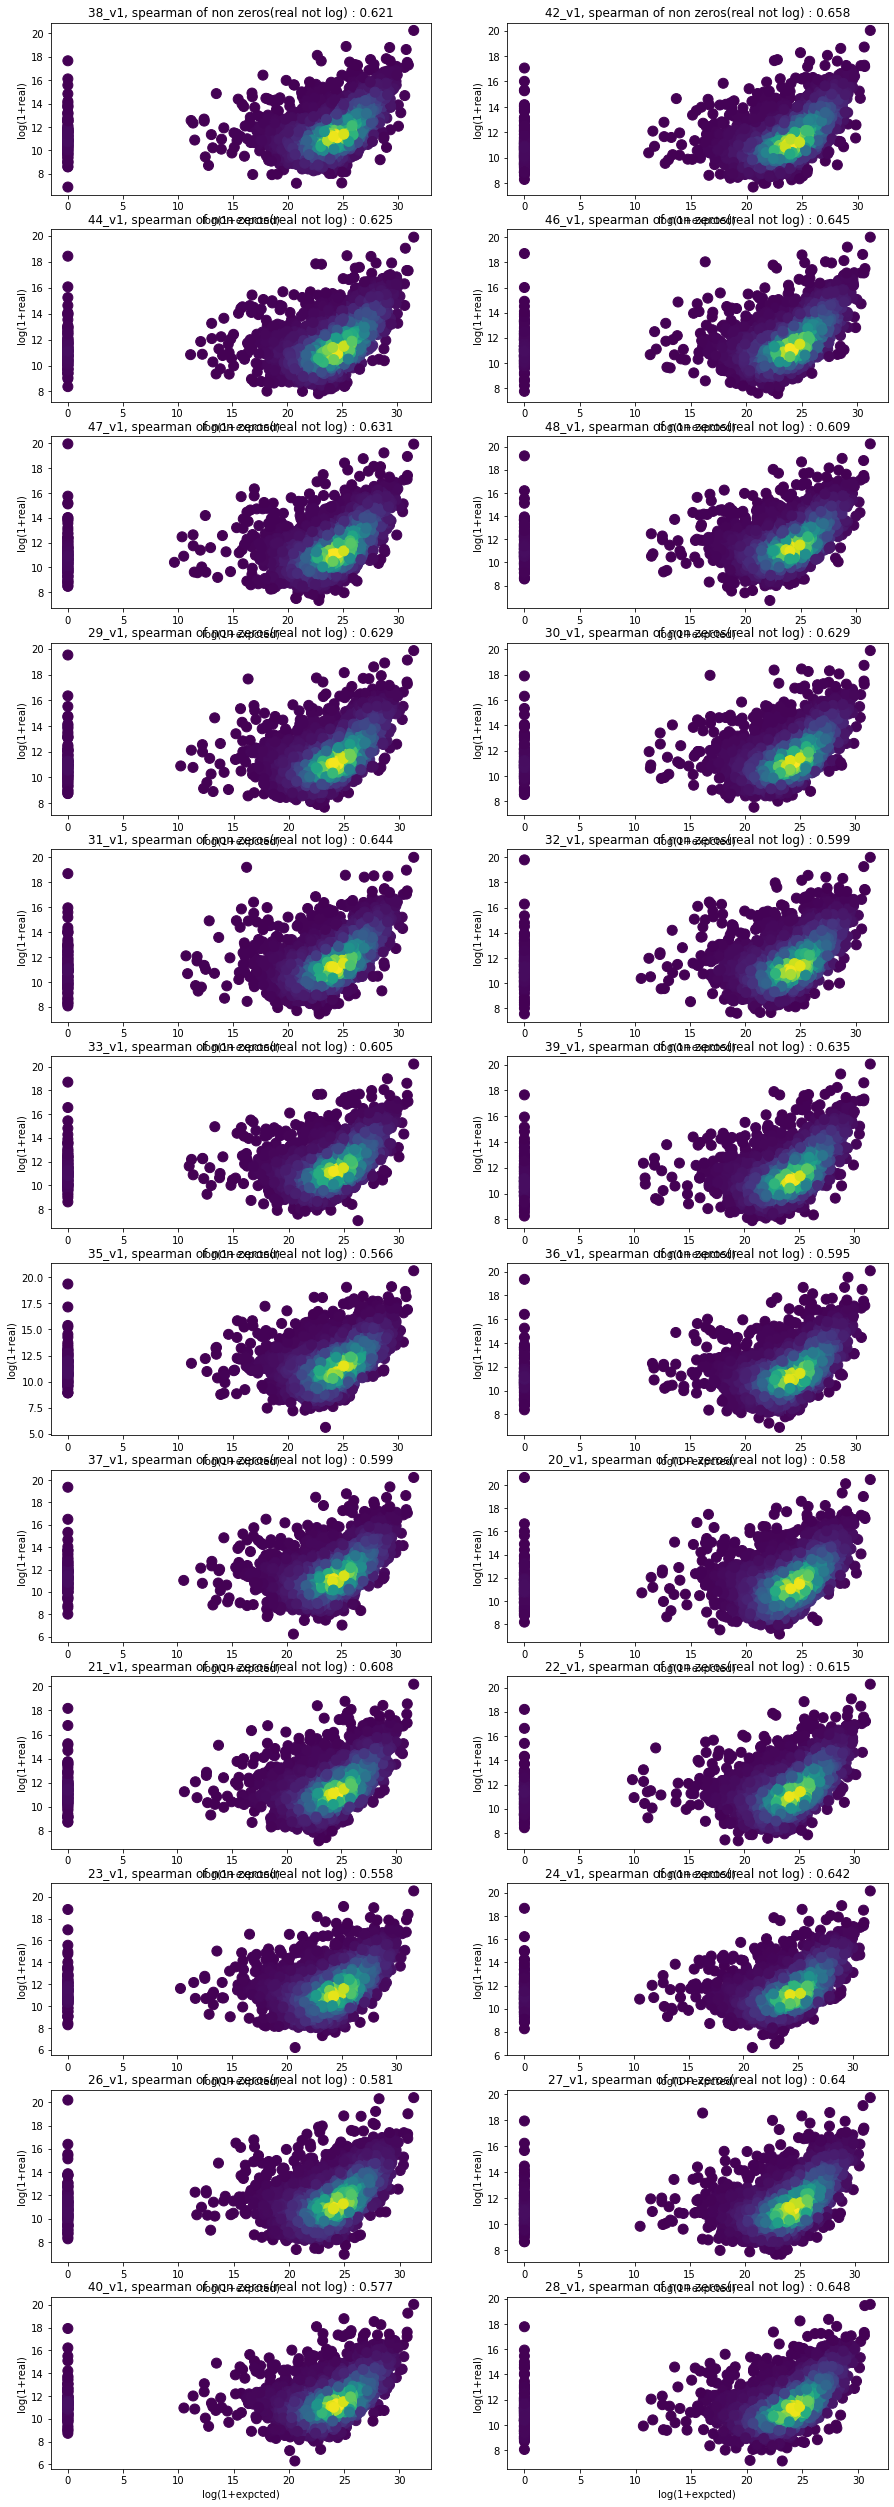

<Figure size 432x288 with 0 Axes>

In [31]:
plot_expcted_mixtures_vs_real_mixtures(expected_mixtures_intensity_tc,B_intensity,lims = None)

### expected_mixtures vs real_mixtures - top 90%

here


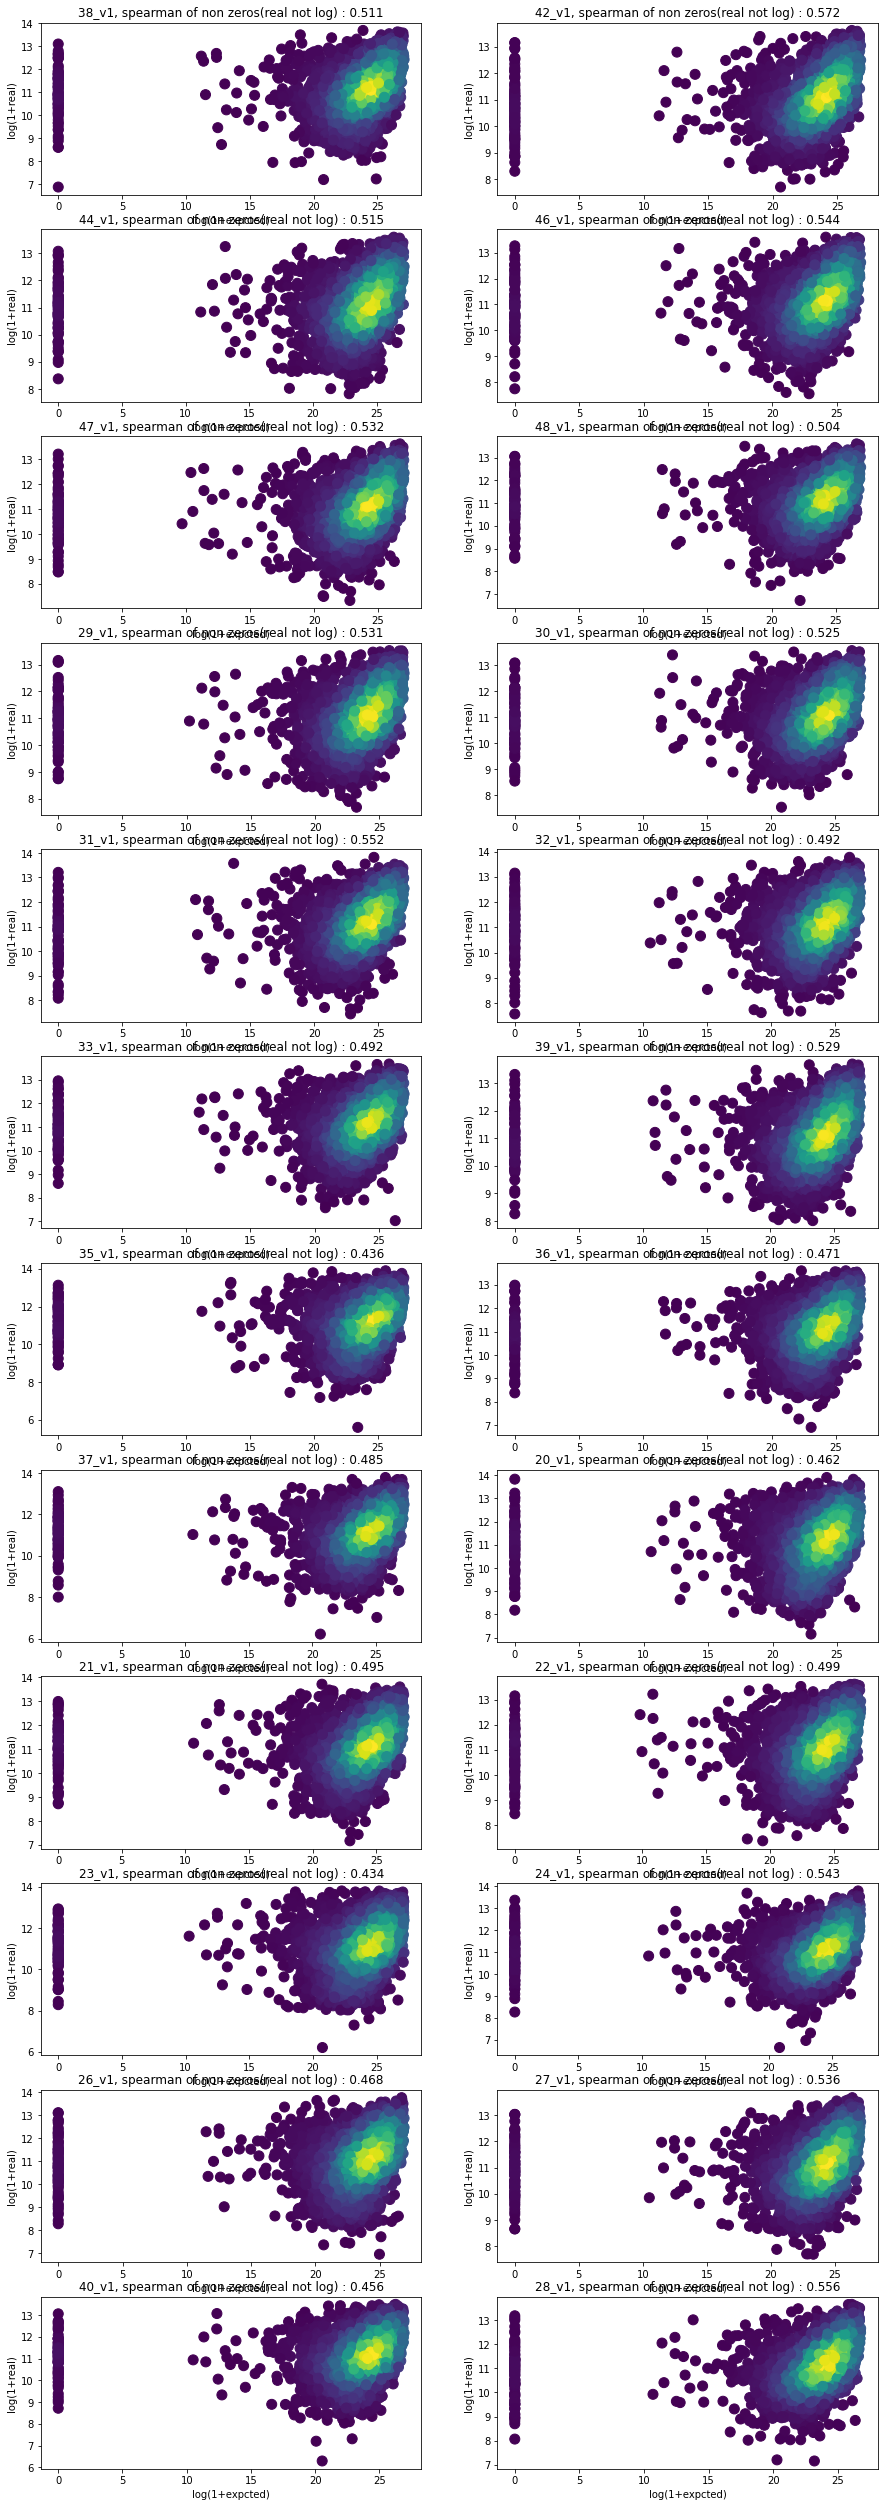

<Figure size 432x288 with 0 Axes>

In [32]:
plot_expcted_mixtures_vs_real_mixtures(expected_mixtures_intensity_tc,B_intensity,lims = None,percantile_to_take=0.9)

### gene across paitents

In [33]:
melted_expcted_mixtures = pd.melt(expected_mixtures_intensity_tc.reset_index(),id_vars="Gene names").set_index(["Gene names","mixtures"])["value"]
melted_real_mixtures = pd.melt(B_intensity.reset_index(),id_vars="Gene names").rename(columns = {"variable":"mixtures"}).set_index(["Gene names","mixtures"])["value"]


In [34]:
corr_list = [] 
corrd_list = []
for gene in expected_mixtures_intensity_tc.index : 
    exp_gene = expected_mixtures_intensity_tc.loc[gene].sort_index()
    real_gene = B_intensity.loc[gene].sort_index()

    mutual_mix = exp_gene.index.intersection(real_gene.index)
    if mutual_mix.shape[0] < 20 : continue


    corr = np.log(1+ exp_gene.loc[mutual_mix]).corr(np.log(1 + real_gene.loc[mutual_mix]),method="spearman")
    corr_list.append(corr)
    corrd_list.append(list(zip(np.log(1+ exp_gene.loc[mutual_mix]).values,np.log(1 + real_gene.loc[mutual_mix]).values)))


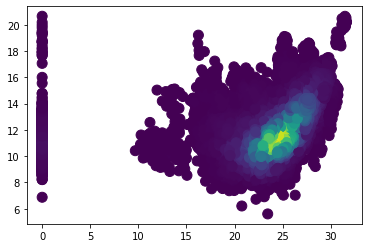

In [35]:
import itertools
all_corrds = list(itertools.chain(*corrd_list))
all_corrds_df = pd.DataFrame(all_corrds).head(50000)

x = all_corrds_df[0]
y = all_corrds_df[1]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, axs = plt.subplots(1,1)

axs.scatter(x, y, c=z,s=100)

In [36]:
x

0        27.384037
1        28.070649
2        27.584060
3        28.158590
4        28.030574
           ...    
49995    24.518974
49996    25.036119
49997    24.527965
49998    24.933863
49999    24.424148
Name: 0, Length: 50000, dtype: float64

C:\Users\Shenorr\AppData\Roaming\Python\Python36\site-packages\numpy\lib\histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Shenorr\AppData\Roaming\Python\Python36\site-packages\numpy\lib\histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([  24.,  108.,  412.,  861., 1081., 1128.,  748.,  336.,   80.,
           6.]),
 array([-0.67652174, -0.52886957, -0.38121739, -0.23356522, -0.08591304,
         0.06173913,  0.2093913 ,  0.35704348,  0.50469565,  0.65234783,
         0.8       ]),
 <BarContainer object of 10 artists>)

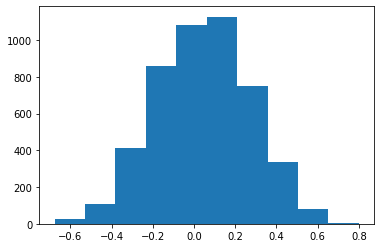

In [37]:
plt.hist(corr_list)

In [38]:
melted_expcted_mixtures

Gene names  mixtures
A2M         38_v1       1.086992e+12
AAAS        38_v1       8.188452e+10
AACS        38_v1       5.678030e+09
AAK1        38_v1       1.585413e+11
AARS        38_v1       4.375692e+11
                            ...     
ZSWIM8      28_v1       8.484951e+09
ZW10        28_v1       5.600181e+10
ZYG11B      28_v1       4.869766e+09
ZYX         28_v1       5.040753e+11
ZZEF1       28_v1       1.168142e+11
Name: value, Length: 117120, dtype: float64

# mRNA figures

## mrna profile with  cytof to mrna - no Total counts

### build mixtures with the granulocytes proportions

In [39]:
nx_rna_granulocytes = nx_rna_cell_df_tc[['eosinophil','basophil','neutrophil']].mean(axis=1)
tpm_rna_granulocytes = tpm_rna_cell_df_tc[['eosinophil','basophil','neutrophil']].mean(axis=1)

###  build expected mixtures

In [40]:
granulocytes_part_nx=pd.DataFrame(data = nx_rna_granulocytes[:,np.newaxis].dot(gran_proportions["GR.TOTAL"][:,np.newaxis].T),columns=gran_proportions.index,index=nx_rna_granulocytes.index)
pb_part_nx = nx_rna_Cytof_cell.dot(cytof_count_of_nx_rna)*gran_proportions["PB.TOTAL"]

granulocytes_part_tpm=pd.DataFrame(data = tpm_rna_granulocytes[:,np.newaxis].dot(gran_proportions["GR.TOTAL"][:,np.newaxis].T),columns=gran_proportions.index,index=tpm_rna_granulocytes.index)
pb_part_tpm = tpm_rna_Cytof_cell.dot(cytof_count_of_tpm_rna)*gran_proportions["PB.TOTAL"]

mutual_genes = granulocytes_part_nx.index.intersection(granulocytes_part_nx.index)

expected_mixtures_nx_rna = pb_part_nx.reindex(mutual_genes)  + granulocytes_part_nx.reindex(mutual_genes)
expected_mixtures_tpm_rna = pb_part_tpm.reindex(mutual_genes)  + granulocytes_part_tpm.reindex(mutual_genes)

In [41]:
gran_proportions["GR.TOTAL"] + cytof_count_of_nx_rna*gran_proportions["PB.TOTAL"]

mixtures            38_v1     42_v1     42_v2     42_v3     44_v1     44_v2  \
B cells          0.597355  0.629201  0.555262  0.613513  0.692101  0.647828   
Monocytes        0.698472  0.666310  0.574848  0.648924  0.793578  0.701761   
Na?ve CD4 Tcell  0.611929  0.715881  0.630912  0.669659  0.686866  0.611911   
Na?ve CD8 Tcell  0.594079  0.659881  0.574164  0.623275  0.669777  0.596730   

mixtures            44_v3     46_v1     46_v2     46_v3  ...     26_v3  \
B cells          0.658508  0.649411  0.660982  0.742795  ...  0.672764   
Monocytes        0.695771  0.730154  0.736942  0.790419  ...  0.686671   
Na?ve CD4 Tcell  0.617208  0.718310  0.705585  0.781235  ...  0.686676   
Na?ve CD8 Tcell  0.596759  0.673243  0.671859  0.751831  ...  0.650375   

mixtures            27_v1     27_v2     27_v3     40_v1     28_v1     28_v2  \
B cells          0.739136  0.739230  0.722221  0.567651  0.616328  0.616229   
Monocytes        0.785654  0.815737  0.787527  0.581136  0.633163  0.636553   
Na?ve CD4 Tcell  0.793323  0.768585  0.751481  0.650501  0.705657  0.700792   
Na?ve CD8 Tcell  0.736607  0.730407  0.705853  0.596621  0.667195  0.658598   

mixtures            28_v3     40_v2     40_v3  
B cells          0.632421  0.480730  0.601863  
Monocytes        0.663262  0.487758  0.625383  
Na?ve CD4 Tcell  0.698603  0.549008  0.636286  
Na?ve CD8 Tcell  0.665702  0.500164  0.600704  

[4 rows x 72 columns]

### expected_mixtures vs real_mixtures

here


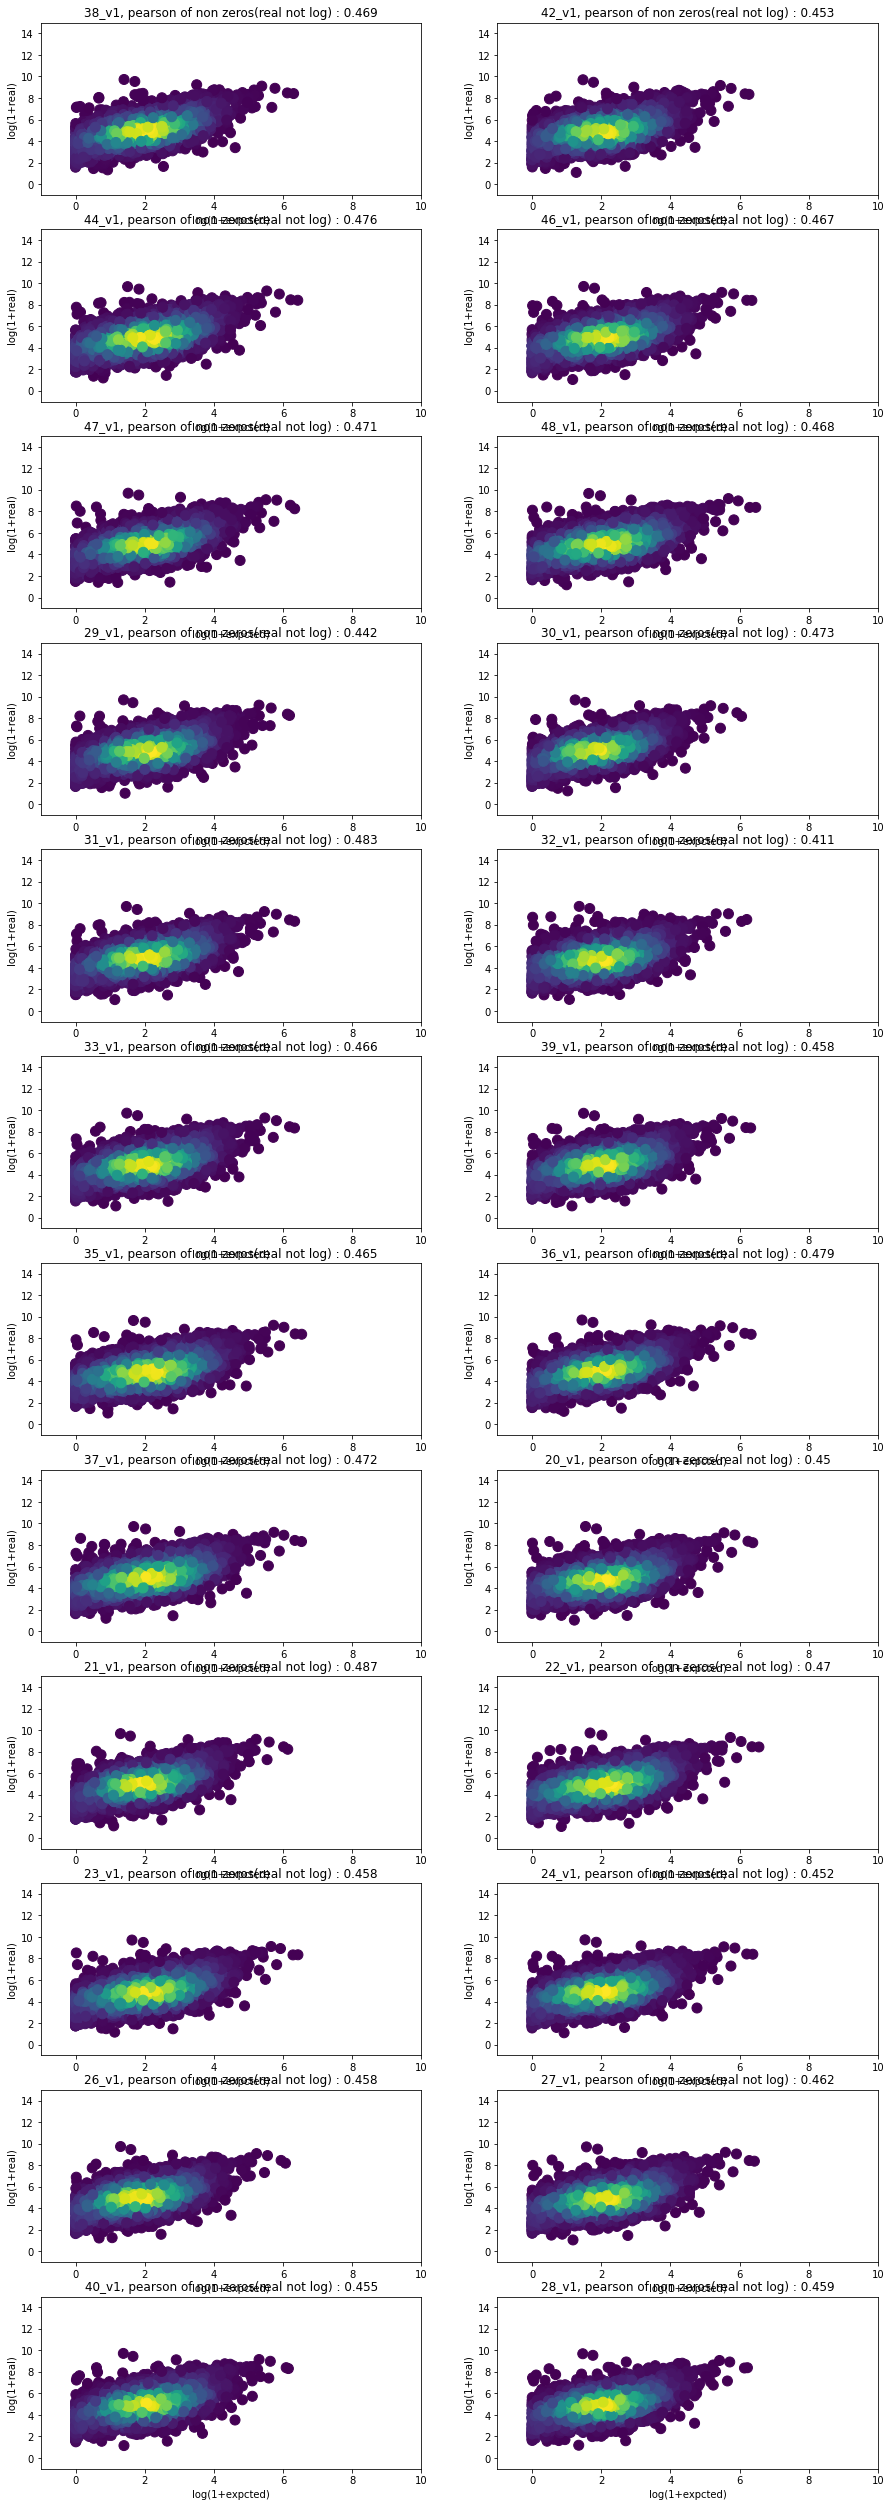

<Figure size 432x288 with 0 Axes>

In [42]:
norm_method = "nx"

_B_gx_ibd = B_gx_ibd.copy()[[col for col  in B_gx_ibd.columns if ("v1" in col)]]
if norm_method == "nx" :
    _expected_mixtures_nx_rna = expected_mixtures_nx_rna[_B_gx_ibd.columns]
    plot_expcted_mixtures_vs_real_mixtures(_expected_mixtures_nx_rna,_B_gx_ibd,as_log=True,lims = [[-1,10],[-1,15]],correlation_type =  "pearson")

if norm_method == "tpm" :
    _expected_mixtures_tpm_rna = expected_mixtures_tpm_rna[_B_gx_ibd.columns]
    plot_expcted_mixtures_vs_real_mixtures(_expected_mixtures_tpm_rna,_B_gx_ibd,as_log=True,correlation_type =  "pearson")

## mrna profile with  cytof to mrna - with Total counts

# mixed 

## mrna profile with cytof to protein 

here


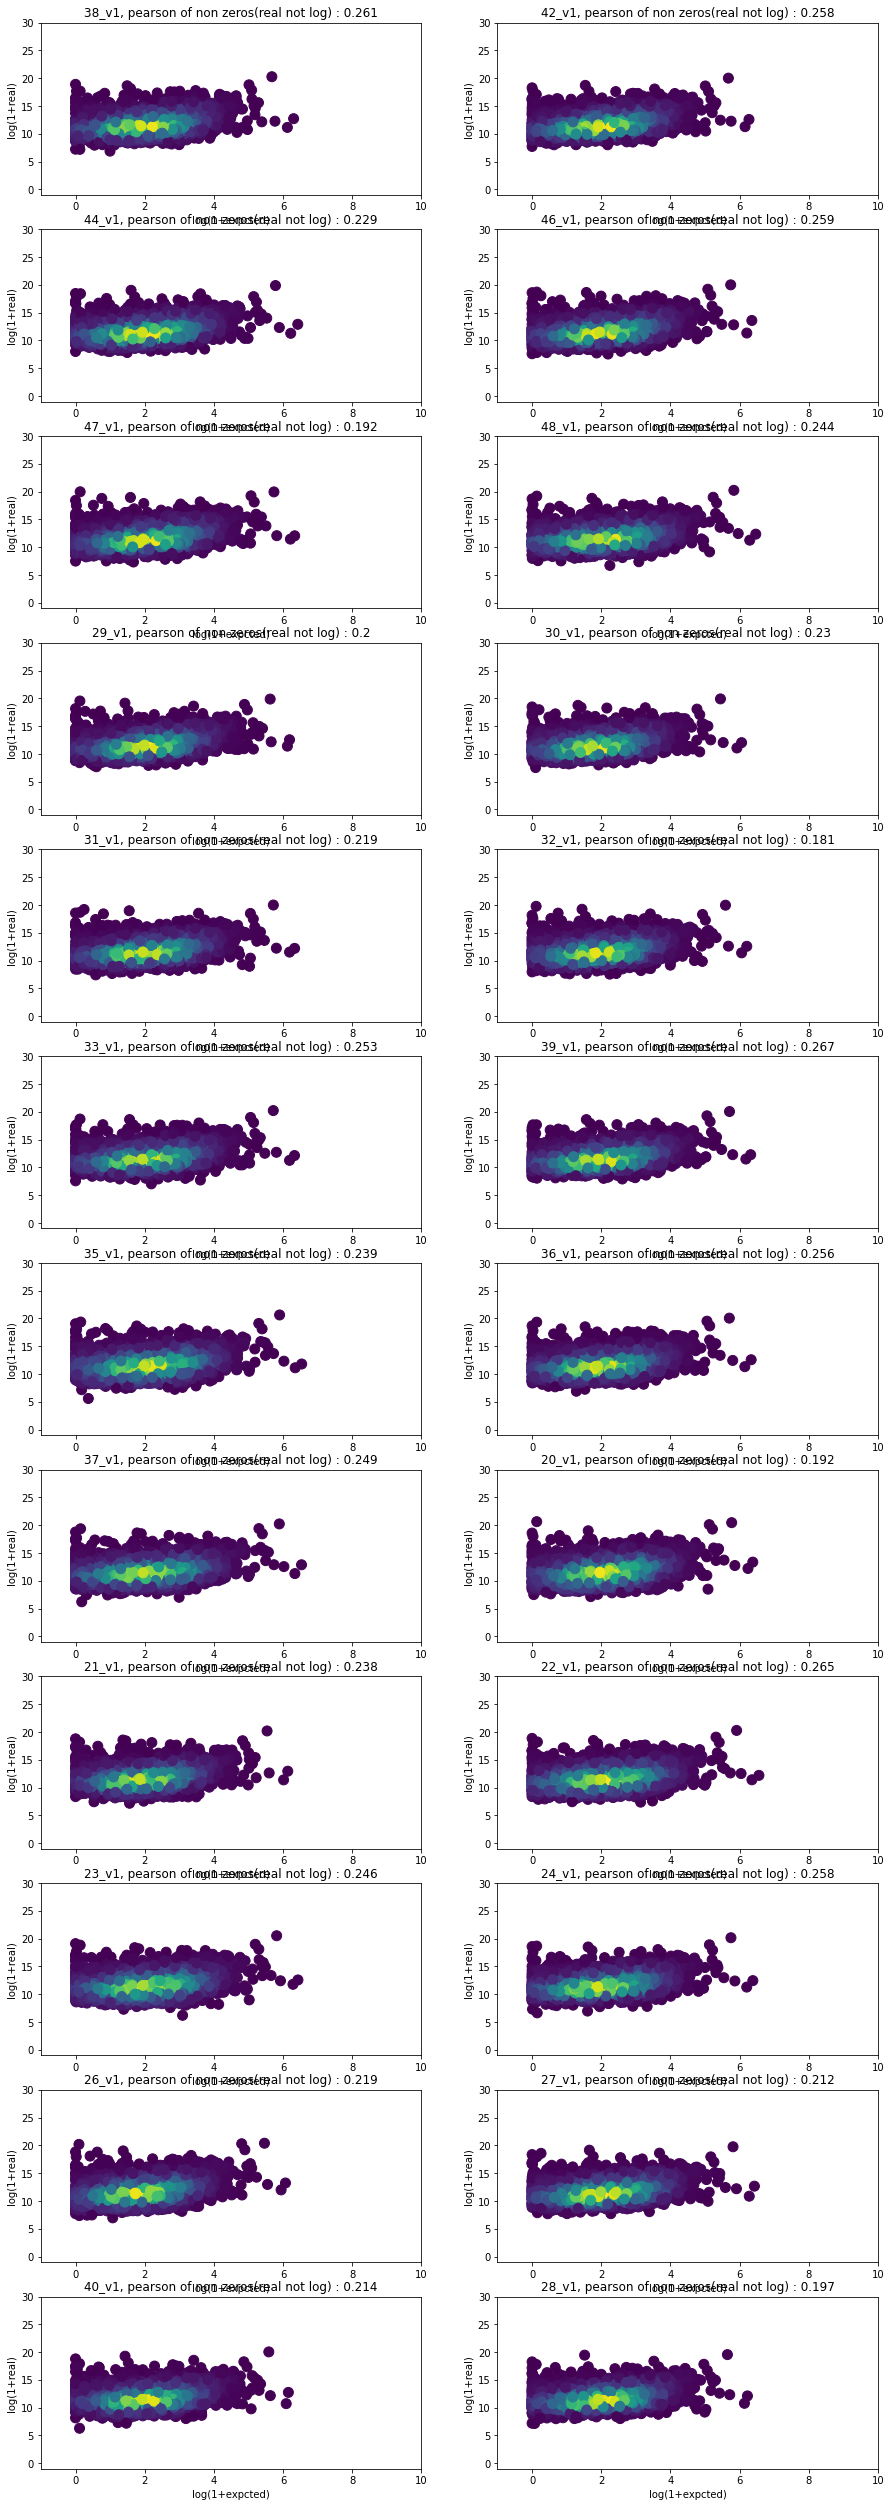

<Figure size 432x288 with 0 Axes>

In [43]:
rel_col = [col for col in expected_mixtures_nx_rna.columns if "v1" in  col ]
plot_expcted_mixtures_vs_real_mixtures(expected_mixtures_nx_rna[rel_col],B_intensity[rel_col],lims = [[-1,10],[-1,30]],correlation_type =  "pearson")

## mrna profile with cytof to protein

here


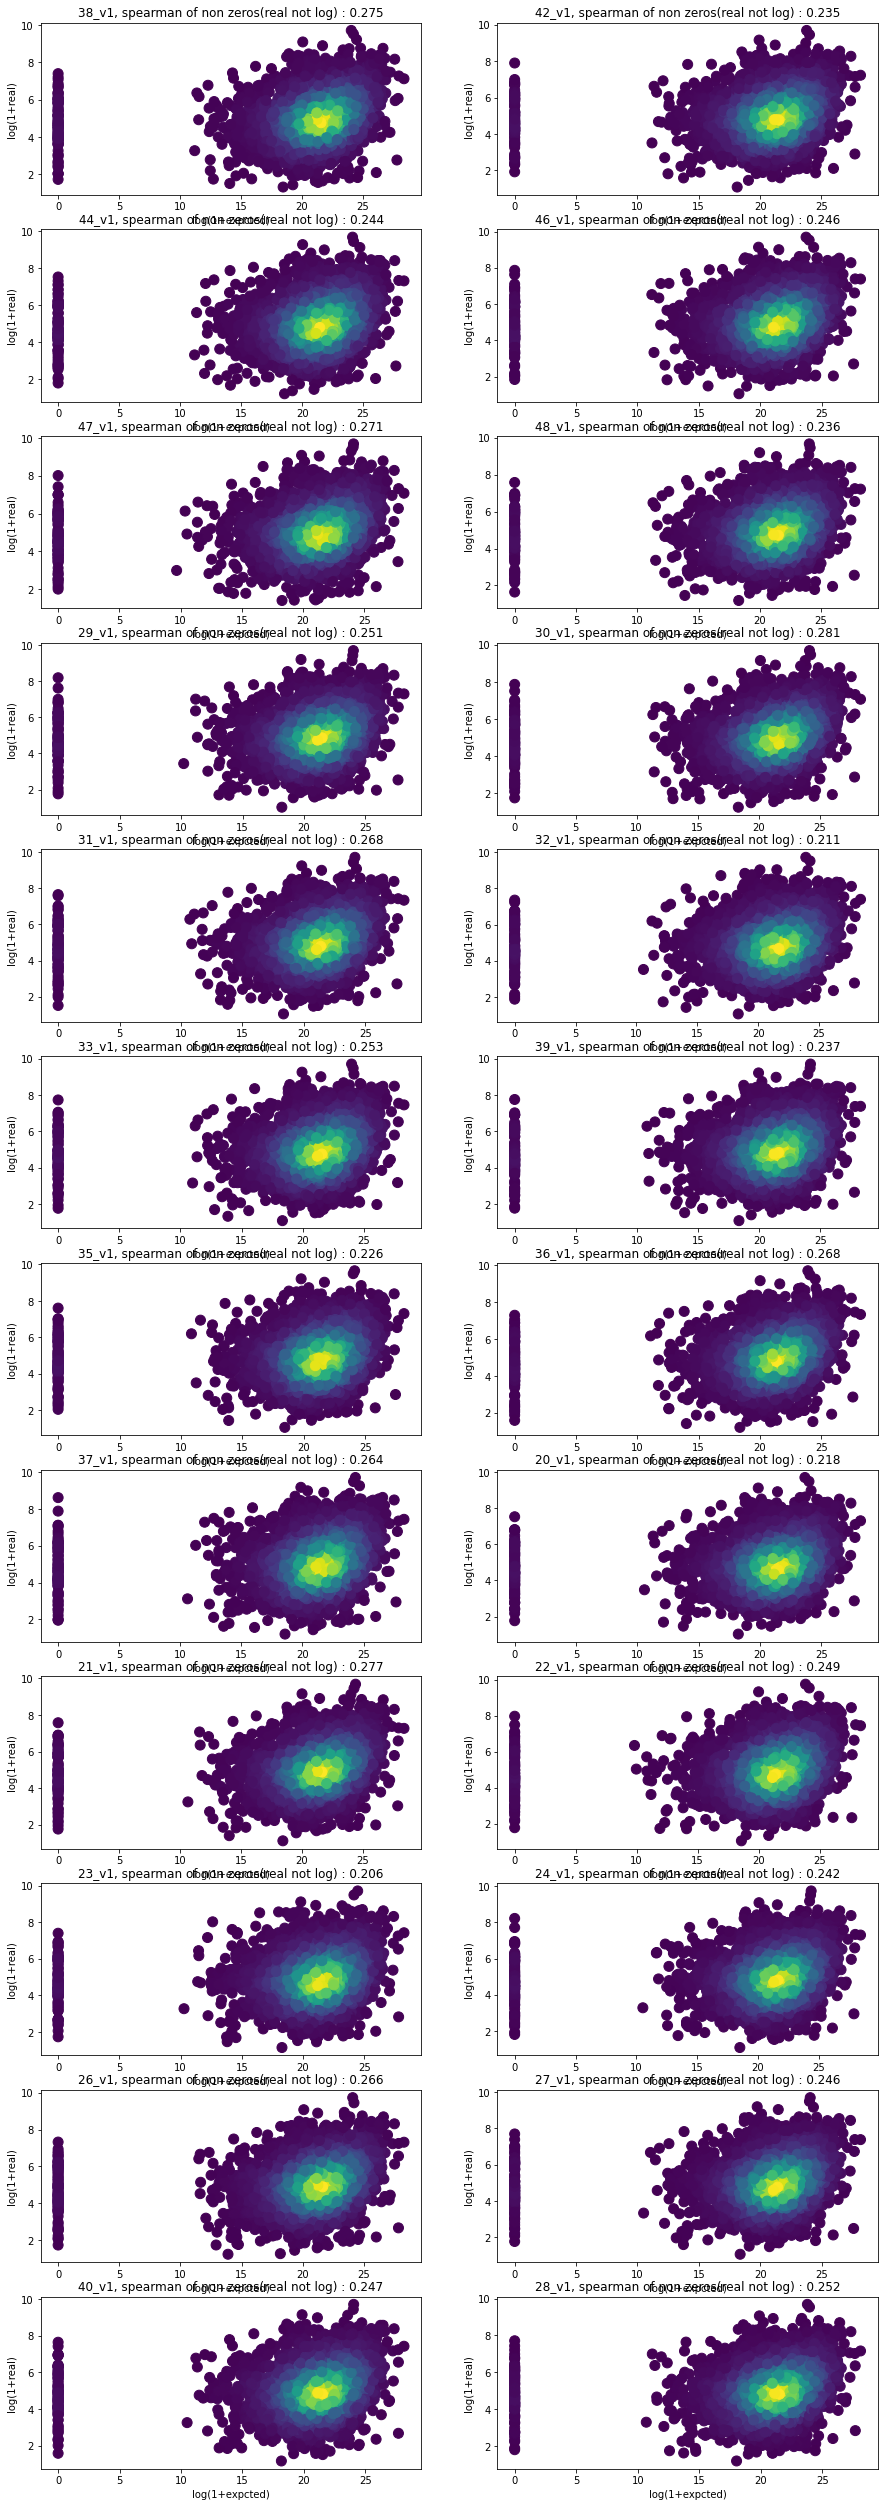

<Figure size 432x288 with 0 Axes>

In [44]:
plot_expcted_mixtures_vs_real_mixtures(expected_mixtures_intensity,B_gx_ibd,lims=None)

# test - comparing the two signatures

In [45]:
plt.plot(seq_data, chance_to_zero, 'k-')
# plt.fill_between(x, y-error, y+error)
plt.xlabel("protein counts")
plt.ylabel("chance to zero")
plt.show()

NameError: name 'seq_data' is not defined